U-Net Base model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/25
71/71 [==============================] - 64s 816ms/step - loss: 0.0395 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/25
71/71 [==============================] - 80s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/25
71/71 [==============================] - 40s 565ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/25
71/71 [==============================] - 39s 555ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/25
71/71 [==============================] - 40s 561ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/25
71/71 [==============================] - 40s 560ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000

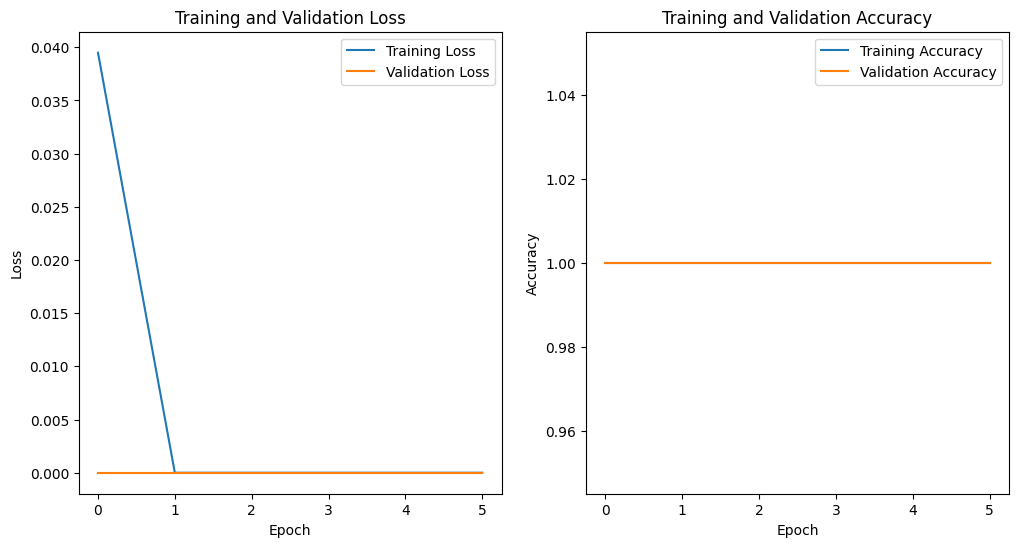

23/23 [==============================] - 10s 451ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Loss: 0.0
Test Accuracy: 1.0


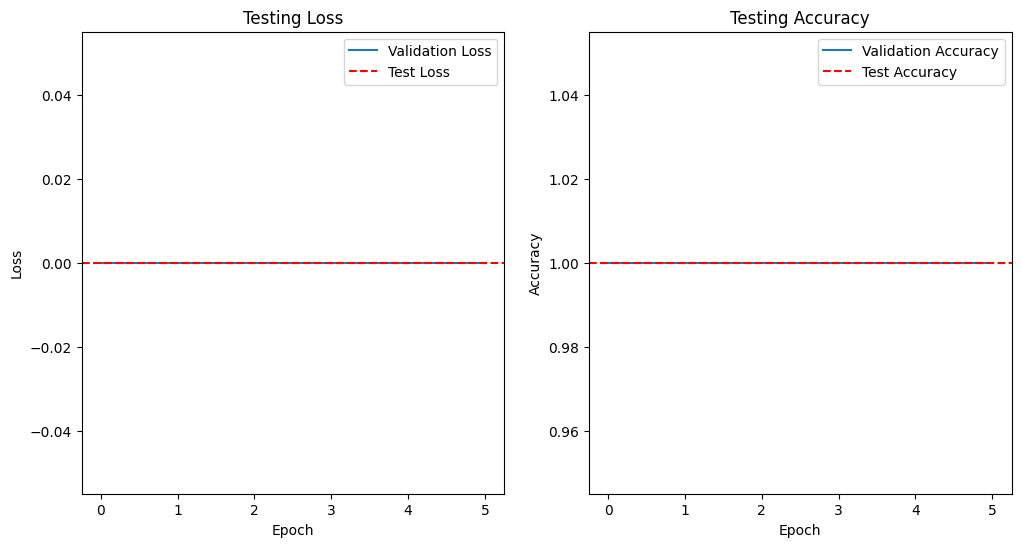

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import xml.etree.ElementTree as ET

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages'
masks_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/Annotations'

# Check if the images and masks directories exist
if not os.path.exists(images_path) or not os.path.exists(masks_path):
    raise ValueError("Directory not found.")

images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.xml')])

if len(mask_files) == 0:
    raise ValueError("No mask files found.")

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def create_segmentation_masks(xml_path, image_size):
    if not os.path.isfile(xml_path):
        raise FileNotFoundError(f"XML file '{xml_path}' does not exist.")
    tree = ET.parse(xml_path)
    root = tree.getroot()

    mask = np.zeros(image_size, dtype=np.uint8)
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        if bbox is None:
            continue
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        xmin = max(min(xmin, image_size[1]), 0)
        xmax = max(min(xmax, image_size[1]), 0)
        ymin = max(min(ymin, image_size[0]), 0)
        ymax = max(min(ymax, image_size[0]), 0)

        if xmax <= xmin or ymax <= ymin:
            continue
        mask[ymin:ymax, xmin:xmax] = 1

    if np.sum(mask) == 0:
        return None
    return mask

def adjust_data(img, mask):
    img = img / 255.0
    mask = mask / 255.0
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return img, mask

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size
        # Filtering out the paths where the mask would be None (empty or invalid annotations)
        self.valid_indices = [i for i, xml_path in enumerate(self.masks_paths) if create_segmentation_masks(xml_path, self.image_size) is not None]
        self.images_paths = [self.images_paths[i] for i in self.valid_indices]
        self.masks_paths = [self.masks_paths[i] for i in self.valid_indices]

    def __len__(self):
        # This makes sure the DataGenerator works even if the number of images isn't divisible by the batch_size.
        return (len(self.valid_indices) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = min((idx + 1) * self.batch_size, len(self.images_paths))

        x = np.zeros((end - start, *self.image_size, 1), dtype=np.float32)
        y = np.zeros((end - start, *self.image_size, 1), dtype=np.float32)

        for i, img_path in enumerate(self.images_paths[start:end]):
            xml_path = self.masks_paths[start:end][i]  # Synchronized access

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = create_segmentation_masks(xml_path, self.image_size)

            if img is None or mask is None:
                continue  # Skip invalid samples

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            x[i], y[i] = adjust_data(img, mask)

        return x, y

def unet(input_size=(256, 256, 1), start_filters=64):
    inputs = Input(input_size)
    conv1 = Conv2D(start_filters, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(start_filters, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(start_filters * 2, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(start_filters * 2, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(start_filters * 4, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(start_filters * 4, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(start_filters * 8, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(start_filters * 8, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(start_filters * 16, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(start_filters * 16, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2DTranspose(start_filters * 8, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(start_filters * 8, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(start_filters * 8, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(start_filters * 4, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(start_filters * 4, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(start_filters * 4, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(start_filters * 2, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(start_filters * 2, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(start_filters * 2, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(start_filters, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(start_filters, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(start_filters, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    output = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)
    return model

model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

try:
    history = model.fit(
        train_gen,
        epochs=25,
        validation_data=val_gen,
        callbacks=[early_stopping],
        verbose=1  # Add verbose output for more detailed logs
    )
except Exception as e:
    print(f"An error occurred: {e}")
    # Optionally, add more diagnostics or save the current state here

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import cv2
import math

# Compute Intersection over Union (IoU) for segmentation masks
def compute_iou_masks(y_true, y_pred):
    intersection_area = 0
    union_area = 0

    for mask_true, mask_pred in zip(y_true, y_pred):
        intersection = np.logical_and(mask_true, mask_pred)
        union = np.logical_or(mask_true, mask_pred)

        intersection_area += np.sum(intersection)
        union_area += np.sum(union)

    if union_area == 0:
        return 0

    return intersection_area / union_area

# Compute Dice coefficient for segmentation masks
def compute_dice_boxes(y_true, y_pred):
    dice_scores = []

    for box_true, box_pred in zip(y_true, y_pred):
        intersection = np.sum(box_true * box_pred)
        dice = (2. * intersection) / (np.sum(box_true) + np.sum(box_pred))
        dice_scores.append(dice)

    return np.mean(dice_scores)

# Placeholder function for creating segmentation masks from XML
def create_segmentation_masks(xml_path, image_size):
    # This function should be implemented based on how your XML annotations are formatted.
    pass

def create_segmentation_masks_array(xml_paths, image_size):
    masks = []
    for xml_path in xml_paths:
        mask = create_segmentation_masks(xml_path, image_size)
        if mask is not None:
            masks.append(mask)
    return np.array(masks)

# Assuming test_images and test_masks are defined
# Predict segmentation masks for test images
y_pred_masks = []
for image_path in test_images:
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    pred_mask = model.predict(img)
    y_pred_masks.append(pred_mask.squeeze())

# Create segmentation masks for ground truth test masks
y_true_masks = create_segmentation_masks_array(test_masks, (256, 256))

iou_boxes = compute_iou_masks(y_true_masks, y_pred_masks)
dice_boxes = compute_dice_boxes(y_true_masks, y_pred_masks)

print("Intersection over Union (IoU) for Segmentation Boxes:", iou_boxes)
print("Dice Coefficient for Segmentation Boxes:", dice_boxes)


1/1 [==============================] - 0s 16ms/step
Intersection over Union (IoU) for Segmentation Boxes: 0
Dice Coefficient for Segmentation Boxes: nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


23/23 [==============================] - 4s 161ms/step


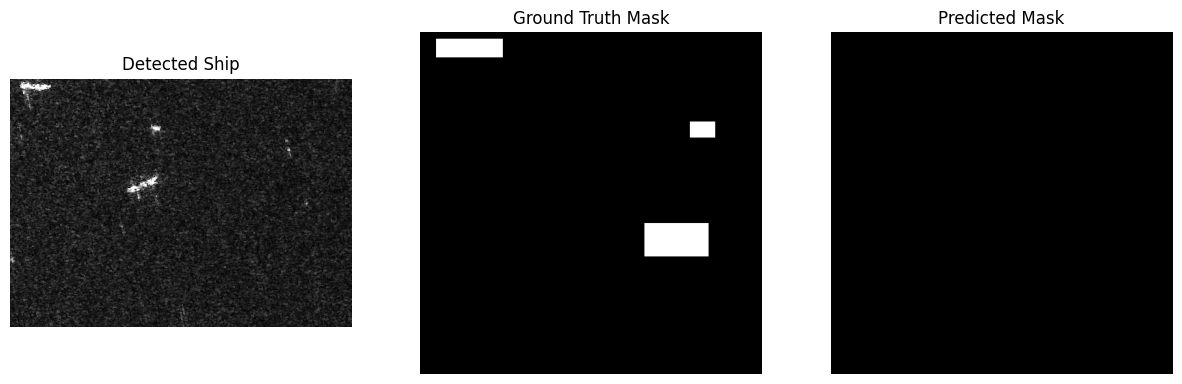

TypeError: Image data of dtype object cannot be converted to float

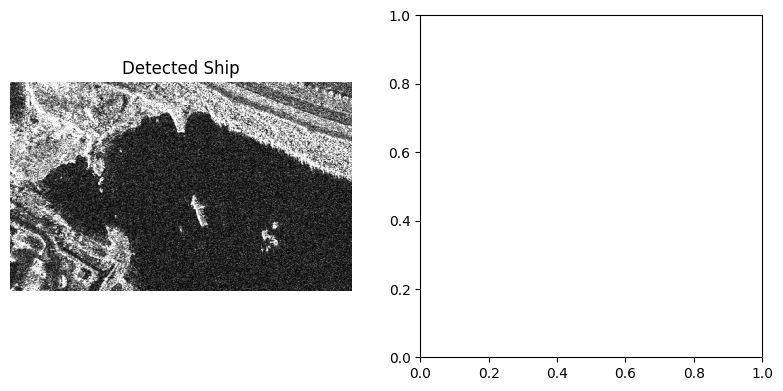

In [ ]:
import cv2
import matplotlib.pyplot as plt

def visualize_bounding_boxes(images, masks, predictions):
    num_images = len(images)
    for i in range(num_images):
        image_path = images[i]
        mask_path = masks[i]
        prediction = predictions[i]

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = create_segmentation_masks(mask_path, (256, 256))

        # Convert predictions to binary mask
        pred_mask_bin = prediction > 0.1
          # Threshold to create binary mask

        # Find contours from the binary segmentation mask
        contours, _ = cv2.findContours((pred_mask_bin * 255).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Draw bounding box for each contour on the original image
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Blue color bounding box

        plt.figure(figsize=(15, 5))

        # Plot original image with bounding box
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Detected Ship")
        plt.axis('off')

        # Plot ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Plot predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(prediction, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

y_pred = model.predict(test_gen)
# Visualize bounding boxes on some sample images
visualize_bounding_boxes(test_images[:5], test_masks[:5], y_pred_masks[:5])

UNet++

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, UpSampling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import xml.etree.ElementTree as ET

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages'
masks_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/Annotations'

# Check if the images and masks directories exist
if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

# Get list of image files and mask files
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.xml')])

print(len(images), len(mask_files))

# Check if mask files are found
if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(images)
print(mask_files)

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255.0
    mask = mask / 255.0
    return img, mask

def create_segmentation_masks(xml_path, image_size):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        mask = np.zeros(image_size, dtype=np.uint8)

        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            mask[ymin:ymax, xmin:xmax] = 1

        return mask
    except FileNotFoundError:
        print(f"XML file '{xml_path}' not found.")
        return None

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)

        for i, (img_path, xml_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError(f"Could not load image '{img_path}'.")
            mask = create_segmentation_masks(xml_path, self.image_size)
            if mask is None:
                raise ValueError(f"Could not create mask for image '{img_path}'.")

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img, mask = adjust_data(img, mask)

            img = np.expand_dims(img, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            x[i], y[i] = img, mask

        return x, y

def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def unet_plus_plus(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    conv_blocks = []  # To store output tensors from each encoding block
    pool = inputs
    for i in range(4):  # Assuming there are 4 encoding blocks
        conv1 = Conv2D(32 * 2**i, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool)
        conv2 = Conv2D(32 * 2**i, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
        conv_blocks.append(conv2)
        if i < 3:  # Perform max pooling except for the last block
            pool = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    bottleneck = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_blocks[-1])
    bottleneck = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(bottleneck)

    # Decoder
    up_blocks = []  # To store output tensors from each decoding block
    up = bottleneck
    for i in range(3, -1, -1):  # Iterate backward through encoding blocks
        up1 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(up)
        up1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up1)  # Add a convolutional layer to adjust spatial dimensions
        up1 = UpSampling2D(size=(2, 2))(up1)  # Adjust spatial dimensions
        # Adjust spatial dimensions of the tensor from the encoding block
        conv_adjusted = Conv2D(512, 1, activation='relu', padding='same', kernel_initializer='he_normal')(conv_blocks[i])
        concat = concatenate([conv_adjusted, up1], axis=3)
        conv3 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat)
        conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
        up_blocks.append(conv4)
        up = conv4

    # Output layer
    output = Conv2D(1, 1, activation='sigmoid')(up_blocks[-1])

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', psnr])
    return model

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

model = unet_plus_plus(input_size=(256, 256, 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture training history
history = model.fit(train_gen,
                    epochs=25,  # Adjust based on your needs
                    validation_data=val_gen,
                    callbacks=[early_stopping])

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy, test_psnr = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test PSNR:", test_psnr)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1160 1160
['/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000001.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000002.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000003.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000004.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000005.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000006.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000007.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000008.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000009.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000010.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000011.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000012.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 32, 32, 512), (None, 128, 128, 512)]

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score
import math

# Compute Intersection over Union (IoU) for segmentation boxes
def compute_iou_masks(y_true, y_pred):
    intersection_area = 0
    union_area = 0

    for mask_true, mask_pred in zip(y_true, y_pred):
        intersection = np.logical_and(mask_true, mask_pred)
        union = np.logical_or(mask_true, mask_pred)

        intersection_area += np.sum(intersection)
        union_area += np.sum(union)

    # Avoid division by zero
    if union_area == 0:
        return 0

    return intersection_area / union_area

# Compute mean Average Precision (mAP) for segmentation boxes
def compute_map_boxes(y_true, y_pred):
    avg_precision = 0

    for i in range(len(y_true)):
        # Flatten the masks to binary labels
        y_true_flat = y_true[i].flatten()
        y_pred_flat = y_pred[i].flatten()

        # Calculate precision and recall
        precision, recall, _ = precision_recall_curve(y_true_flat, y_pred_flat)

        # Calculate average precision
        avg_precision += average_precision_score(y_true_flat, y_pred_flat)

    return avg_precision / len(y_true)


# Compute Peak Signal to Noise Ratio (PSNR) for segmentation boxes
def compute_psnr_boxes(y_true, y_pred):
    mse_total = 0
    num_samples = len(y_true)

    for box_true, box_pred in zip(y_true, y_pred):
        mse = np.mean((box_true - box_pred) ** 2)
        mse_total += mse

    mse_avg = mse_total / num_samples

    if mse_avg == 0:
        # Handle case when MSE is zero (images are identical)
        return float('inf')  # Set PSNR to infinity or any other predefined value
    else:
        max_pixel = 1.0
        return 20 * math.log10(max_pixel / math.sqrt(mse_avg))


# Compute Dice coefficient for segmentation boxes
def compute_dice_boxes(y_true, y_pred):
    dice_scores = []

    for box_true, box_pred in zip(y_true, y_pred):
        intersection = np.sum(box_true * box_pred)
        dice = (2. * intersection) / (np.sum(box_true) + np.sum(box_pred))
        dice_scores.append(dice)

    return np.mean(dice_scores)

y_pred = model.predict(test_gen)

# Create a data generator for the test dataset without shuffling
test_gen_no_shuffle = DataGenerator(test_images, test_masks, batch_size=batch_size)

# Extract ground truth segmentation masks from the test dataset
y_true = []
for i in range(len(test_gen_no_shuffle)):
    _, batch_y = test_gen_no_shuffle[i]
    y_true.extend(batch_y)

# Convert y_true to a numpy array
y_true = np.array(y_true)

# Ensure the shapes of y_pred and y_true are compatible
if y_pred.shape != y_true.shape:
    raise ValueError("Shapes of y_pred and y_true are not compatible.")


# Assuming y_true and y_pred are lists of segmentation boxes
iou_boxes = compute_iou_masks(y_true, y_pred)
mAP_boxes = compute_map_boxes(y_true, y_pred)
psnr_boxes = compute_psnr_boxes(y_true, y_pred)
dice_boxes = compute_dice_boxes(y_true, y_pred)

print("Intersection over Union (IoU) for Segmentation Boxes:", iou_boxes)
print("Mean Average Precision (mAP) for Segmentation Boxes:", mAP_boxes)
print("Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes:", psnr_boxes)
print("Dice Coefficient for Segmentation Boxes:", dice_boxes)

In [ ]:
sample_images = test_images[:2]
sample_masks = test_masks[:2]

for img_path, mask_path in zip(sample_images, sample_masks):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if the images are loaded successfully
    if img is None or mask is None:
        print(f"Failed to load image or mask: {img_path}, {mask_path}")
        continue

    # Check if the images have valid sizes
    if img.size == 0 or mask.size == 0:
        print(f"Empty image or mask: {img_path}, {mask_path}")
        continue

    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

    img = img / 255.0  # Normalize image

    # Predict mask
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
    pred_mask = np.where(pred_mask > 0.5, 255, 0).astype(np.uint8)

    # Plot original image, ground truth mask, and predicted mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask[:, :, 0], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[:, :, 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()

Attention UNet model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1160 1160
['/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000001.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000002.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000003.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000004.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000005.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000006.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000007.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000008.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000009.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000010.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000011.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000012.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/

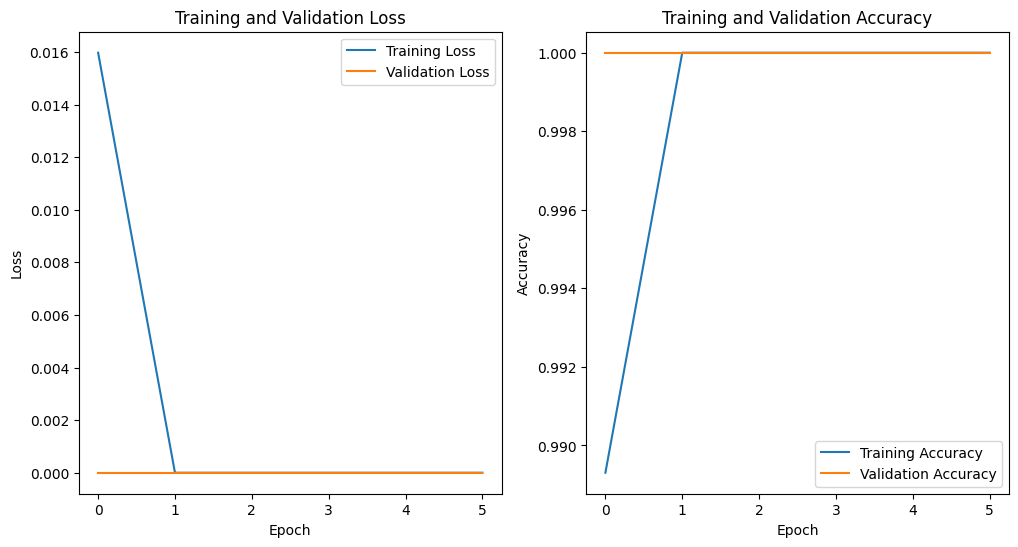

29/29 [==============================] - 63s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Loss: 0.0
Test Accuracy: 1.0


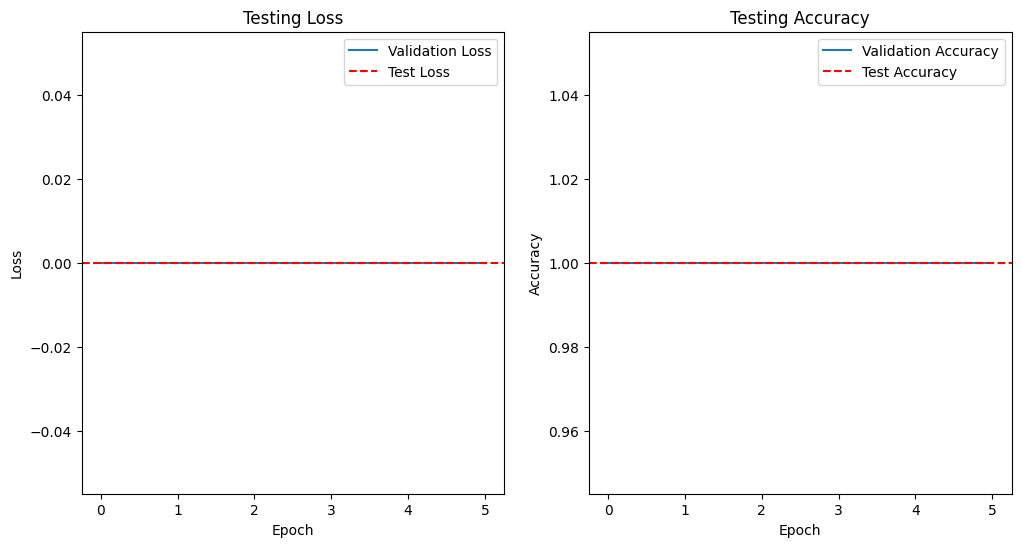

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, multiply
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import xml.etree.ElementTree as ET

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages'
masks_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/Annotations'

# Check if the images and masks directories exist
if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

# Get list of image files and mask files
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.xml')])

print(len(images), len(mask_files))

# Check if mask files are found
if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(images)
print(mask_files)

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

def create_segmentation_masks(xml_path, image_size):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        mask = np.zeros(image_size, dtype=np.uint8)

        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            mask[ymin:ymax, xmin:xmax] = 1

        return mask
    except FileNotFoundError:
        print(f"XML file '{xml_path}' not found.")
        return None

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)

        for i, (img_path, xml_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError(f"Could not load image '{img_path}'.")
            mask = create_segmentation_masks(xml_path, self.image_size)
            if mask is None:
                raise ValueError(f"Could not create mask for image '{img_path}'.")

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            x[i], y[i] = adjust_data(img, mask)

        return x, y

def attention_unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    att6 = attention_block(up6, drop4)
    merge6 = concatenate([up6, att6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    att7 = attention_block(up7, conv3)
    merge7 = concatenate([up7, att7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    att8 = attention_block(up8, conv2)
    merge8 = concatenate([up8, att8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    att9 = attention_block(up9, conv1)
    merge9 = concatenate([up9, att9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    # Output layer
    output = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def attention_block(x, g, inter_channel=256):
    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], kernel_initializer='he_normal')(x)
    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], kernel_initializer='he_normal')(g)
    f = tf.keras.activations.relu(concatenate([theta_x, phi_g]))
    psi_f = Conv2D(1, [1, 1], strides=[1, 1], kernel_initializer='he_normal')(f)
    rate = tf.keras.activations.sigmoid(psi_f)
    att_x = multiply([x, rate])
    return att_x

model = attention_unet(input_size=(256, 256, 1))

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture training history
history = model.fit(train_gen,
                    epochs=25,  # Adjust based on your needs
                    validation_data=val_gen,
                    callbacks=[early_stopping])

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score
import math

# Compute Intersection over Union (IoU) for segmentation boxes
def compute_iou_masks(y_true, y_pred):
    intersection_area = 0
    union_area = 0

    for mask_true, mask_pred in zip(y_true, y_pred):
        intersection = np.logical_and(mask_true, mask_pred)
        union = np.logical_or(mask_true, mask_pred)

        intersection_area += np.sum(intersection)
        union_area += np.sum(union)

    # Avoid division by zero
    if union_area == 0:
        return 0

    return intersection_area / union_area

# Compute mean Average Precision (mAP) for segmentation boxes
def compute_map_boxes(y_true, y_pred):
    avg_precision = 0

    for i in range(len(y_true)):
        # Flatten the masks to binary labels
        y_true_flat = y_true[i].flatten()
        y_pred_flat = y_pred[i].flatten()

        # Calculate precision and recall
        precision, recall, _ = precision_recall_curve(y_true_flat, y_pred_flat)

        # Calculate average precision
        avg_precision += average_precision_score(y_true_flat, y_pred_flat)

    return avg_precision / len(y_true)


# Compute Peak Signal to Noise Ratio (PSNR) for segmentation boxes
def compute_psnr_boxes(y_true, y_pred):
    mse_total = 0
    num_samples = len(y_true)

    for box_true, box_pred in zip(y_true, y_pred):
        mse = np.mean((box_true - box_pred) ** 2)
        mse_total += mse

    mse_avg = mse_total / num_samples

    if mse_avg == 0:
        # Handle case when MSE is zero (images are identical)
        return float('inf')  # Set PSNR to infinity or any other predefined value
    else:
        max_pixel = 1.0
        return 20 * math.log10(max_pixel / math.sqrt(mse_avg))


# Compute Dice coefficient for segmentation boxes
def compute_dice_boxes(y_true, y_pred):
    dice_scores = []

    for box_true, box_pred in zip(y_true, y_pred):
        intersection = np.sum(box_true * box_pred)
        dice = (2. * intersection) / (np.sum(box_true) + np.sum(box_pred))
        dice_scores.append(dice)

    return np.mean(dice_scores)

y_pred = model.predict(test_gen)

# Create a data generator for the test dataset without shuffling
test_gen_no_shuffle = DataGenerator(test_images, test_masks, batch_size=batch_size)

# Extract ground truth segmentation masks from the test dataset
y_true = []
for i in range(len(test_gen_no_shuffle)):
    _, batch_y = test_gen_no_shuffle[i]
    y_true.extend(batch_y)

# Convert y_true to a numpy array
y_true = np.array(y_true)

# Ensure the shapes of y_pred and y_true are compatible
if y_pred.shape != y_true.shape:
    raise ValueError("Shapes of y_pred and y_true are not compatible.")


# Assuming y_true and y_pred are lists of segmentation boxes
iou_boxes = compute_iou_masks(y_true, y_pred)
mAP_boxes = compute_map_boxes(y_true, y_pred)
psnr_boxes = compute_psnr_boxes(y_true, y_pred)
dice_boxes = compute_dice_boxes(y_true, y_pred)

print("Intersection over Union (IoU) for Segmentation Boxes:", iou_boxes)
print("Mean Average Precision (mAP) for Segmentation Boxes:", mAP_boxes)
print("Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes:", psnr_boxes)
print("Dice Coefficient for Segmentation Boxes:", dice_boxes)

29/29 [==============================] - 7s 218ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

Intersection over Union (IoU) for Segmentation Boxes: 0
Mean Average Precision (mAP) for Segmentation Boxes: 0.0
Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes: inf
Dice Coefficient for Segmentation Boxes: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

In [ ]:
sample_images = test_images[:2]
sample_masks = test_masks[:2]

for img_path, mask_path in zip(sample_images, sample_masks):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if the images are loaded successfully
    if img is None or mask is None:
        print(f"Failed to load image or mask: {img_path}, {mask_path}")
        continue

    # Check if the images have valid sizes
    if img.size == 0 or mask.size == 0:
        print(f"Empty image or mask: {img_path}, {mask_path}")
        continue

    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

    img = img / 255.0  # Normalize image

    # Predict mask
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
    pred_mask = np.where(pred_mask > 0.5, 255, 0).astype(np.uint8)

    # Plot original image, ground truth mask, and predicted mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask[:, :, 0], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[:, :, 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()

Failed to load image or mask: /content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000334.jpg, /content/drive/MyDrive/BBox_SSDD/voc_style/Annotations/000334.xml
Failed to load image or mask: /content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000645.jpg, /content/drive/MyDrive/BBox_SSDD/voc_style/Annotations/000645.xml


PSPNet model

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, AveragePooling2D, UpSampling2D, Activation, Add
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import xml.etree.ElementTree as ET

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages'
masks_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/Annotations'

# Check if the images and masks directories exist
if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

# Get list of image files and mask files
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.xml')])

print(len(images), len(mask_files))

# Check if mask files are found
if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(images)
print(mask_files)

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

def create_segmentation_masks(xml_path, image_size):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        mask = np.zeros(image_size, dtype=np.uint8)

        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            mask[ymin:ymax, xmin:xmax] = 1

        return mask
    except FileNotFoundError:
        print(f"XML file '{xml_path}' not found.")
        return None

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)

        for i, (img_path, xml_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError(f"Could not load image '{img_path}'.")
            mask = create_segmentation_masks(xml_path, self.image_size)
            if mask is None:
                raise ValueError(f"Could not create mask for image '{img_path}'.")

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            x[i], y[i] = adjust_data(img, mask)

        return x, y

def pspnet(input_shape=(256, 256, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    x = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    pool1 = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    x = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    pool2 = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    x = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    pool3 = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    drop4 = tf.keras.layers.Dropout(0.5)(x)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    x = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    x = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    drop5 = tf.keras.layers.Dropout(0.5)(x)

    # Pyramid Pooling Module
    pool_sizes = [1, 2, 3, 6]
    pooled_outputs = []
    for size in pool_sizes:
        pooled_out = AveragePooling2D(pool_size=(input_shape[0] // size, input_shape[1] // size))(drop5)
        pooled_out = Conv2D(512, 1, activation='relu')(pooled_out)
        pooled_out = UpSampling2D(size=(size, size), interpolation='bilinear')(pooled_out)
        pooled_outputs.append(pooled_out)

    x = concatenate(pooled_outputs + [drop5], axis=-1)

    # Decoder
    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)

    x = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)

    x = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)

    x = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)

    outputs = Conv2D(num_classes, 1, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = pspnet(input_shape=(256, 256, 1), num_classes=2)

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture training history
history = model.fit(train_gen,
                    epochs=25,  # Adjust based on your needs
                    validation_data=val_gen,
                    callbacks=[early_stopping])

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1160 1160
['/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000001.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000002.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000003.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000004.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000005.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000006.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000007.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000008.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000009.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000010.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000011.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000012.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/

ValueError: Exception encountered when calling layer "average_pooling2d_3" (type AveragePooling2D).

Negative dimension size caused by subtracting 256 from 16 for '{{node average_pooling2d_3/AvgPool}} = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 256, 256, 1], padding="VALID", strides=[1, 256, 256, 1]](Placeholder)' with input shapes: [?,16,16,1024].

Call arguments received by layer "average_pooling2d_3" (type AveragePooling2D):
  • inputs=tf.Tensor(shape=(None, 16, 16, 1024), dtype=float32)

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score
import math

# Compute Intersection over Union (IoU) for segmentation boxes
def compute_iou_boxes(y_true, y_pred):
    intersection_area = 0
    union_area = 0

    for box_true, box_pred in zip(y_true, y_pred):
        x1_t, y1_t, x2_t, y2_t = box_true
        x1_p, y1_p, x2_p, y2_p = box_pred

        # Calculate intersection coordinates
        x1_i = max(x1_t, x1_p)
        y1_i = max(y1_t, y1_p)
        x2_i = min(x2_t, x2_p)
        y2_i = min(y2_t, y2_p)

        # Calculate intersection area
        intersection_area += max(0, x2_i - x1_i) * max(0, y2_i - y1_i)

        # Calculate union area
        union_area += (x2_t - x1_t) * (y2_t - y1_t) + (x2_p - x1_p) * (y2_p - y1_p) - intersection_area

    # Avoid division by zero
    if union_area == 0:
        return 0

    return intersection_area / union_area

# Compute mean Average Precision (mAP) for segmentation boxes
def compute_map_boxes(y_true, y_pred):
    avg_precision = 0

    for i in range(len(y_true)):
        precision, recall, _ = precision_recall_curve(y_true[i], y_pred[i])
        avg_precision += average_precision_score(y_true[i], y_pred[i])

    return avg_precision / len(y_true)

# Compute Peak Signal to Noise Ratio (PSNR) for segmentation boxes
def compute_psnr_boxes(y_true, y_pred):
    mse_total = 0

    for box_true, box_pred in zip(y_true, y_pred):
        mse = np.mean((box_true - box_pred) ** 2)
        mse_total += mse

    mse_avg = mse_total / len(y_true)
    max_pixel = 1.0

    return 20 * math.log10(max_pixel / math.sqrt(mse_avg))

# Compute Dice coefficient for segmentation boxes
def compute_dice_boxes(y_true, y_pred):
    dice_scores = []

    for box_true, box_pred in zip(y_true, y_pred):
        intersection = np.sum(box_true * box_pred)
        dice = (2. * intersection) / (np.sum(box_true) + np.sum(box_pred))
        dice_scores.append(dice)

    return np.mean(dice_scores)

y_pred = model.predict(test_gen)

# Create a data generator for the test dataset without shuffling
test_gen_no_shuffle = DataGenerator(test_images, test_masks, batch_size=batch_size)

# Extract ground truth segmentation masks from the test dataset
y_true = []
for i in range(len(test_gen_no_shuffle)):
    _, batch_y = test_gen_no_shuffle[i]
    y_true.extend(batch_y)

# Convert y_true to a numpy array
y_true = np.array(y_true)

# Ensure the shapes of y_pred and y_true are compatible
if y_pred.shape != y_true.shape:
    raise ValueError("Shapes of y_pred and y_true are not compatible.")

# Assuming y_true and y_pred are lists of segmentation boxes
iou_boxes = compute_iou_boxes(y_true, y_pred)
mAP_boxes = compute_map_boxes(y_true, y_pred)
psnr_boxes = compute_psnr_boxes(y_true, y_pred)
dice_boxes = compute_dice_boxes(y_true, y_pred)

# Debug statements
print("Intersection over Union (IoU) for Segmentation Boxes:", iou_boxes)
print("Mean Average Precision (mAP) for Segmentation Boxes:", mAP_boxes)
print("Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes:", psnr_boxes)
print("Dice Coefficient for Segmentation Boxes:", dice_boxes)

29/29 [==============================] - 12s 428ms/step


ValueError: too many values to unpack (expected 4)

In [ ]:
# Generate predictions on sample images and visualize the segmentation results
sample_images = test_images[:2]
sample_masks = test_masks[:2]

for img_path, mask_path in zip(sample_images, sample_masks):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(masks_path, mask_path), cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

    img = img / 255.0  # Normalize image

    # Predict mask
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
    pred_mask = np.where(pred_mask > 0.5, 255, 0).astype(np.uint8)

    # Plot original image, ground truth mask, and predicted mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask[:, :, 0], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[:, :, 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()

SegNet Model

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, AveragePooling2D, UpSampling2D, Activation, Add
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import xml.etree.ElementTree as ET

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages'
masks_path = '/content/drive/MyDrive/BBox_SSDD/voc_style/Annotations'

# Check if the images and masks directories exist
if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

# Get list of image files and mask files
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.xml')])

print(len(images), len(mask_files))

# Check if mask files are found
if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(images)
print(mask_files)

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

def create_segmentation_masks(xml_path, image_size):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        mask = np.zeros(image_size, dtype=np.uint8)

        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            mask[ymin:ymax, xmin:xmax] = 1

        return mask
    except FileNotFoundError:
        print(f"XML file '{xml_path}' not found.")
        return None

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)

        for i, (img_path, xml_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError(f"Could not load image '{img_path}'.")
            mask = create_segmentation_masks(xml_path, self.image_size)
            if mask is None:
                raise ValueError(f"Could not create mask for image '{img_path}'.")

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            x[i], y[i] = adjust_data(img, mask)

        return x, y

class MaxPoolingWithArgmax2D(layers.Layer):
    def __init__(self, pool_size=(2, 2), **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.arg_max = None

    def call(self, inputs):
        ksize = [1, self.pool_size[0], self.pool_size[1], 1]
        strides = [1, self.pool_size[0], self.pool_size[1], 1]
        output, arg_max = tf.nn.max_pool_with_argmax(inputs, ksize=ksize, strides=strides, padding='SAME')
        self.arg_max = arg_max
        return output, arg_max

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1] // self.pool_size[0], input_shape[2] // self.pool_size[1], input_shape[3]

    def get_config(self):
        config = super(MaxPoolingWithArgmax2D, self).get_config()
        config.update({'pool_size': self.pool_size})
        return config


class MaxUnpooling2D(layers.Layer):
    def __init__(self, pool_size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        inputs, mask = inputs
        shape = tf.shape(inputs)
        output_shape = (shape[0], shape[1] * self.pool_size[0], shape[2] * self.pool_size[1], shape[3])

        one_hot = tf.one_hot(mask, depth=tf.reduce_max(mask) + 1)
        one_hot = tf.reshape(one_hot, (-1, tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3], tf.shape(one_hot)[-1]))
        output = tf.cast(one_hot, dtype=inputs.dtype) * inputs[:, tf.newaxis]
        return tf.reshape(output, output_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0][0], input_shape[0][1] * self.pool_size[0], input_shape[0][2] * self.pool_size[1], input_shape[0][3]

    def get_config(self):
        config = super(MaxUnpooling2D, self).get_config()
        config.update({'pool_size': self.pool_size})
        return config


def segnet(input_shape=(256, 256, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    x = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    pool1, mask1 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(x)

    x = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    x = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    pool2, mask2 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(x)

    x = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    x = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    pool3, mask3 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(x)

    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    pool4, mask4 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(x)

    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    pool5, mask5 = MaxPoolingWithArgmax2D(pool_size=(2, 2))(x)

    # Decoder
    x = MaxUnpooling2D(pool_size=(2, 2))([pool5, mask5])
    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)

    x = MaxUnpooling2D(pool_size=(2, 2))([x, mask4])
    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)

    x = MaxUnpooling2D(pool_size=(2, 2))([x, mask3])
    x = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)

    x = MaxUnpooling2D(pool_size=(2, 2))([x, mask2])
    x = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)

    x = MaxUnpooling2D(pool_size=(2, 2))([x, mask1])
    x = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    outputs = Conv2D(num_classes, 1, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = pspnet(input_shape=(256, 256, 1), num_classes=2)

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture training history
history = model.fit(train_gen,
                    epochs=25,  # Adjust based on your needs
                    validation_data=val_gen,
                    callbacks=[early_stopping])

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1160 1160
['/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000001.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000002.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000003.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000004.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000005.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000006.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000007.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000008.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000009.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000010.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000011.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/JPEGImages/000012.jpg', '/content/drive/MyDrive/BBox_SSDD/voc_style/

NameError: name 'layers' is not defined

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score
import math

# Compute Intersection over Union (IoU) for segmentation boxes
def compute_iou_boxes(y_true, y_pred):
    intersection_area = 0
    union_area = 0

    for box_true, box_pred in zip(y_true, y_pred):
        x1_t, y1_t, x2_t, y2_t = box_true
        x1_p, y1_p, x2_p, y2_p = box_pred

        # Calculate intersection coordinates
        x1_i = max(x1_t, x1_p)
        y1_i = max(y1_t, y1_p)
        x2_i = min(x2_t, x2_p)
        y2_i = min(y2_t, y2_p)

        # Calculate intersection area
        intersection_area += max(0, x2_i - x1_i) * max(0, y2_i - y1_i)

        # Calculate union area
        union_area += (x2_t - x1_t) * (y2_t - y1_t) + (x2_p - x1_p) * (y2_p - y1_p) - intersection_area

    # Avoid division by zero
    if union_area == 0:
        return 0

    return intersection_area / union_area

# Compute mean Average Precision (mAP) for segmentation boxes
def compute_map_boxes(y_true, y_pred):
    avg_precision = 0

    for i in range(len(y_true)):
        precision, recall, _ = precision_recall_curve(y_true[i], y_pred[i])
        avg_precision += average_precision_score(y_true[i], y_pred[i])

    return avg_precision / len(y_true)

# Compute Peak Signal to Noise Ratio (PSNR) for segmentation boxes
def compute_psnr_boxes(y_true, y_pred):
    mse_total = 0

    for box_true, box_pred in zip(y_true, y_pred):
        mse = np.mean((box_true - box_pred) ** 2)
        mse_total += mse

    mse_avg = mse_total / len(y_true)
    max_pixel = 1.0

    return 20 * math.log10(max_pixel / math.sqrt(mse_avg))

# Compute Dice coefficient for segmentation boxes
def compute_dice_boxes(y_true, y_pred):
    dice_scores = []

    for box_true, box_pred in zip(y_true, y_pred):
        intersection = np.sum(box_true * box_pred)
        dice = (2. * intersection) / (np.sum(box_true) + np.sum(box_pred))
        dice_scores.append(dice)

    return np.mean(dice_scores)

y_pred = model.predict(test_gen)

# Create a data generator for the test dataset without shuffling
test_gen_no_shuffle = DataGenerator(test_images, test_masks, batch_size=batch_size)

# Extract ground truth segmentation masks from the test dataset
y_true = []
for i in range(len(test_gen_no_shuffle)):
    _, batch_y = test_gen_no_shuffle[i]
    y_true.extend(batch_y)

# Convert y_true to a numpy array
y_true = np.array(y_true)

# Ensure the shapes of y_pred and y_true are compatible
if y_pred.shape != y_true.shape:
    raise ValueError("Shapes of y_pred and y_true are not compatible.")

# Assuming y_true and y_pred are lists of segmentation boxes
iou_boxes = compute_iou_boxes(y_true, y_pred)
mAP_boxes = compute_map_boxes(y_true, y_pred)
psnr_boxes = compute_psnr_boxes(y_true, y_pred)
dice_boxes = compute_dice_boxes(y_true, y_pred)

# Debug statements
print("Intersection over Union (IoU) for Segmentation Boxes:", iou_boxes)
print("Mean Average Precision (mAP) for Segmentation Boxes:", mAP_boxes)
print("Peak Signal to Noise Ratio (PSNR) for Segmentation Boxes:", psnr_boxes)
print("Dice Coefficient for Segmentation Boxes:", dice_boxes)

In [ ]:
# Generate predictions on sample images and visualize the segmentation results
sample_images = test_images[:2]
sample_masks = test_masks[:2]

for img_path, mask_path in zip(sample_images, sample_masks):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(masks_path, mask_path), cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

    img = img / 255.0  # Normalize image

    # Predict mask
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
    pred_mask = np.where(pred_mask > 0.5, 255, 0).astype(np.uint8)

    # Plot original image, ground truth mask, and predicted mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask[:, :, 0], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[:, :, 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1160 images.
Found 1160 mask files.
Epoch 1/50
87/87 [==============================] - 33s 180ms/step - loss: 0.5521 - accuracy: 0.8772 - val_loss: 0.3400 - val_accuracy: 0.9975
Epoch 2/50
87/87 [==============================] - 15s 177ms/step - loss: 0.2381 - accuracy: 1.0000 - val_loss: 0.1312 - val_accuracy: 1.0000
Epoch 3/50
87/87 [==============================] - 16s 178ms/step - loss: 0.0864 - accuracy: 1.0000 - val_loss: 0.0531 - val_accuracy: 1.0000
Epoch 4/50
87/87 [==============================] - 15s 174ms/step - loss: 0.0388 - accuracy: 1.0000 - val_loss: 0.0274 - val_accuracy: 1.0000
Epoch 5/50
87/87 [==============================] - 15s 172ms/step - loss: 0.0215 - accuracy: 1.0000 - val_loss: 0.0164 - val_accuracy: 1.0000
Epoch 6/50
87/87 [==============================] - 15s 175ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Ground Truth Masks Shape: (15204352,)
Predicted Masks Shape: (15204352,)
Unique Values in Ground Truth Masks: [0.]
Unique Values in Predicted Masks: [0]
Intersection over Union (IoU): nan
Dice Coefficient: nan


<ipython-input-3-e1b78f112ef7>:175: RuntimeWarning: invalid value encountered in scalar divide
  return intersection / union
<ipython-input-3-e1b78f112ef7>:180: RuntimeWarning: invalid value encountered in scalar divide
  dice = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
<ipython-input-3-e1b78f112ef7>:187: RuntimeWarning: divide by zero encountered in scalar divide
  psnr = 20 * np.log10(max_pixel / np.sqrt(mse))


Peak Signal to Noise Ratio (PSNR): inf
F1 Score: 0.0
Mean Average Precision (mAP): -0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


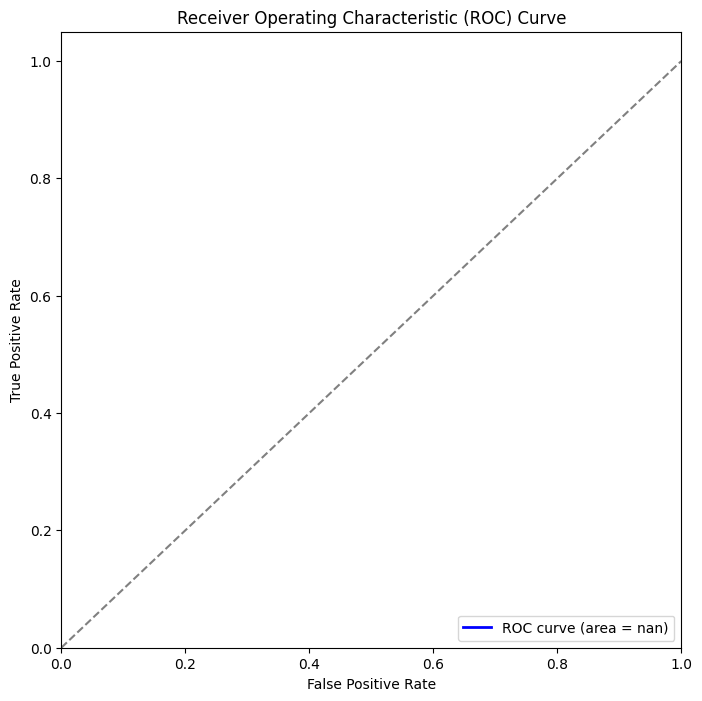

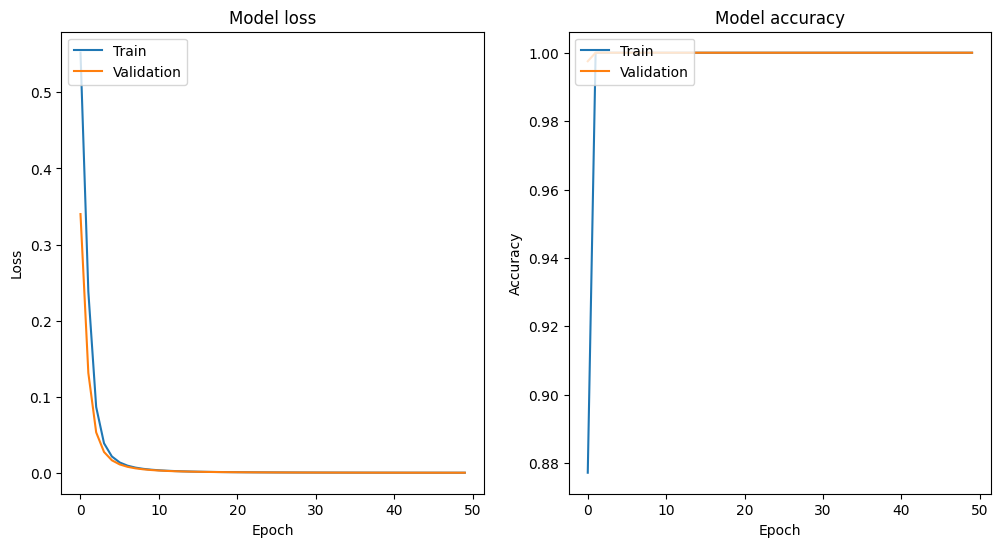

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, roc_curve, auc
from skimage.metrics import peak_signal_noise_ratio
from tensorflow.keras.callbacks import EarlyStopping
import xml.etree.ElementTree as ET

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/JPEGImages'
masks_path = '/content/drive/MyDrive/Annotations'

# Check if the images and masks directories exist
if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

# Get list of image files and mask files
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.xml')])

# Check if mask files are found
if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(f"Found {len(images)} images.")
print(f"Found {len(mask_files)} mask files.")

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

def parse_xml(file_path):
    """Parse an XML file and extract bounding box coordinates."""
    tree = ET.parse(file_path)
    root = tree.getroot()
    boxes = []
    for member in root.findall('object'):
        xmin = int(member.find('bndbox/xmin').text)
        ymin = int(member.find('bndbox/ymin').text)
        xmax = int(member.find('bndbox/xmax').text)
        ymax = int(member.find('bndbox/ymax').text)
        boxes.append((xmin, ymin, xmax, ymax))
    return boxes

def create_mask_from_boxes(image_shape, boxes):
    """Create a binary mask from bounding boxes."""
    mask = np.zeros(image_shape, dtype=np.float32)
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        mask[ymin:ymax, xmin:xmax] = 1
    return mask

# Update DataGenerator to use the new mask creation method
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.image_size)
            img = np.expand_dims(img, axis=-1)

            boxes = parse_xml(mask_path.replace('.jpg', '.xml'))  # Assuming XML files share the name with images
            mask = create_mask_from_boxes(self.image_size, boxes)
            mask = np.expand_dims(mask, axis=-1)

            x[i], y[i] = adjust_data(img, mask)

        return x, y

def conv_block(inputs, filters):
    conv = Conv2D(filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = BatchNormalization()(conv)
    conv = Conv2D(filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    return conv

def upconv_block(inputs, skip_connection, filters):
    upconv = Conv2DTranspose(filters, kernel_size=2, strides=2, padding='same')(inputs)
    merge = concatenate([upconv, skip_connection], axis=3)
    return merge

def unetpp_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder (Contracting Path)
    conv1_1 = conv_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)
    conv2_1 = conv_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)
    conv3_1 = conv_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)

    # Middle Block
    conv4_1 = conv_block(pool3, 256)

    # Decoder (Expanding Path)
    upconv3_2 = upconv_block(conv4_1, conv3_1, 128)
    conv3_2 = conv_block(upconv3_2, 128)
    upconv2_3 = upconv_block(conv3_2, conv2_1, 64)
    conv2_3 = conv_block(upconv2_3, 64)
    upconv1_4 = upconv_block(conv2_3, conv1_1, 32)
    conv1_4 = conv_block(upconv1_4, 32)

    # Output Layer
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(conv1_4)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model = unetpp_model(input_size=(256, 256, 1))

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

# Train the model and capture training history
history = model.fit(train_gen,
                    epochs=50,  # Adjust based on your needs
                    validation_data=val_gen,
                    callbacks=[early_stopping])

# Generate predictions on the test dataset
test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)

# Predict probabilities
y_pred = model.predict(test_gen)

# Flatten the ground truth masks and predictions
y_true_flat = np.concatenate([test_gen[i][1].flatten() for i in range(len(test_gen))])
y_pred_flat = y_pred.flatten()

# Binarize predictions
y_pred_binary = (y_pred_flat > 0.5).astype(int)

# Compute IoU (Jaccard Index)
def compute_iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union

# Compute Dice coefficient
def compute_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice

# Compute PSNR
def compute_psnr(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Compute F1 score
f1 = f1_score(y_true_flat, y_pred_binary)

# Compute mAP
def compute_ap(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return average_precision_score(y_true, y_pred)

mAP = compute_ap(y_true_flat, y_pred_flat)

# Debug statements
print("Ground Truth Masks Shape:", y_true_flat.shape)
print("Predicted Masks Shape:", y_pred_binary.shape)
print("Unique Values in Ground Truth Masks:", np.unique(y_true_flat))
print("Unique Values in Predicted Masks:", np.unique(y_pred_binary))

print("Intersection over Union (IoU):", compute_iou(y_true_flat, y_pred_binary))
print("Dice Coefficient:", compute_dice(y_true_flat, y_pred_binary))
print("Peak Signal to Noise Ratio (PSNR):", compute_psnr(y_true_flat, y_pred_binary))
print("F1 Score:", f1)
print("Mean Average Precision (mAP):", mAP)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true_flat, y_pred_flat)

# Compute ROC area under curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation accuracy

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


29/29 [==============================] - 2s 79ms/step


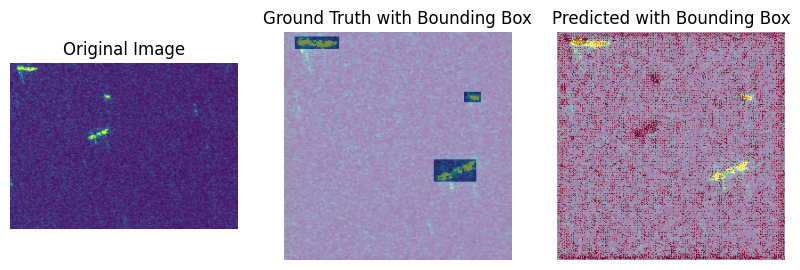

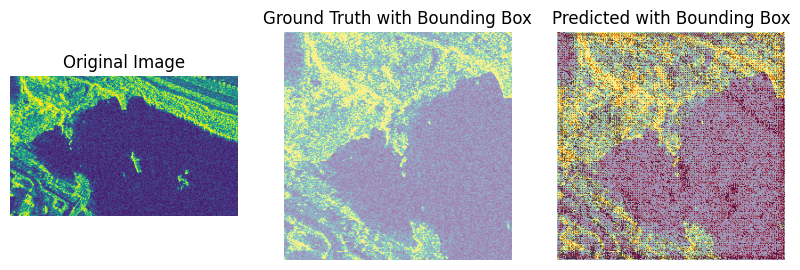

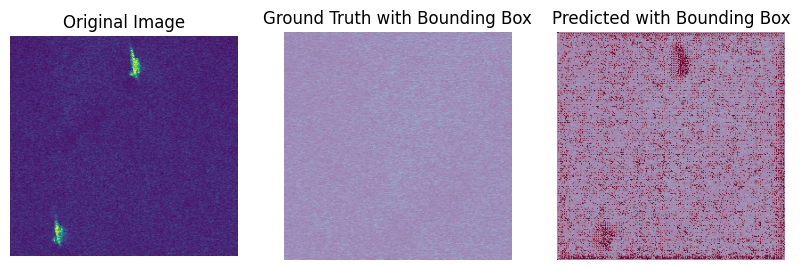

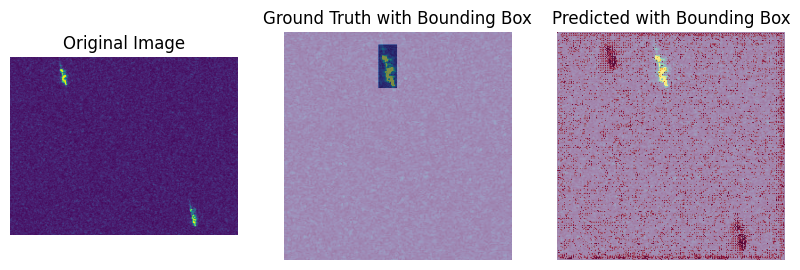

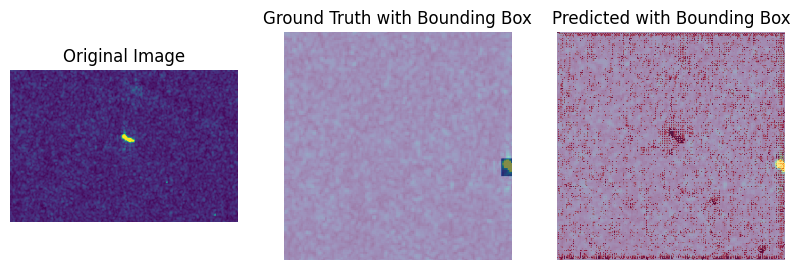

In [ ]:
import matplotlib.pyplot as plt

def create_segmentation_masks(xml_path, image_size):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        mask = np.zeros(image_size, dtype=np.uint8)

        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            mask[ymin:ymax, xmin:xmax] = 1

        return mask
    except FileNotFoundError:
        print(f"XML file '{xml_path}' not found.")
        return None

y_pred_masks = []
for image_path in test_images:
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    pred_mask = model.predict(img)
    y_pred_masks.append(pred_mask.squeeze())

# Visualize bounding boxes on images
def visualize_bounding_boxes(images, masks, predictions):
    num_images = len(images)

    for i in range(num_images):
        image = images[i]
        mask = masks[i]
        prediction = predictions[i]

        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        mask = create_segmentation_masks(mask, (256, 256))
        plt.figure(figsize=(10, 5))

        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')

        # Plot ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.5, cmap='Blues')
        plt.title("Ground Truth with Bounding Box")
        plt.axis('off')

        # Plot predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(image)
        plt.imshow(prediction, alpha=0.5, cmap='Reds')
        plt.title("Predicted with Bounding Box")
        plt.axis('off')

        plt.show()

y_pred = model.predict(test_gen)
# Visualize bounding boxes on some sample images
visualize_bounding_boxes(test_images[:5], test_masks[:5], y_pred_masks[:5])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50
87/87 [==============================] - 60s 381ms/step - loss: 0.0637 - accuracy: 0.9742 - val_loss: 0.0294 - val_accuracy: 1.0000
Epoch 2/50
87/87 [==============================] - 32s 367ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 3/50
87/87 [==============================] - 32s 371ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 4/50
87/87 [==============================] - 34s 393ms/step - loss: 6.5541e-04 - accuracy: 1.0000 - val_loss: 8.6463e-04 - val_accuracy: 1.0000
Epoch 5/50
87/87 [==============================] - 32s 370ms/step - loss: 4.3779e-04 - accuracy: 1.0000 - val_loss: 5.1538e-04 - val_accuracy: 1.0000
Epoch 6/50
87/87 [==============================] - 32s 373ms/step - loss: 3.1512e-04 - accuracy: 1.0000 - val_loss: 3.5656e-04 - val_accura

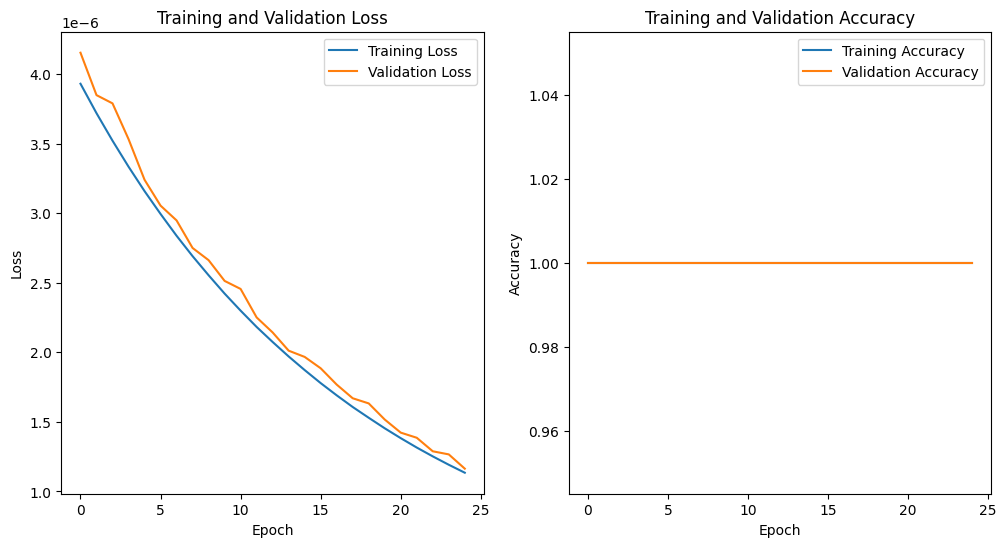

29/29 [==============================] - 3s 111ms/step - loss: 1.1510e-06 - accuracy: 1.0000
Test Loss: 1.1509828254929744e-06
Test Accuracy: 1.0


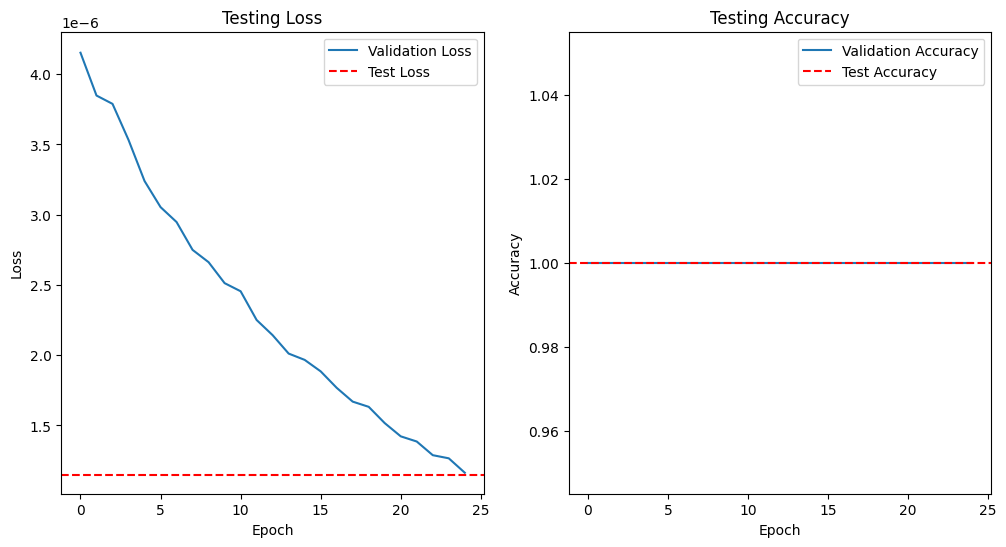

In [ ]:
# Imports and setup
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import xml.etree.ElementTree as ET
from google.colab import drive

# Drive mount
drive.mount('/content/drive')

# Paths setup
images_path = '/content/drive/MyDrive/JPEGImages'
masks_path = '/content/drive/MyDrive/Annotations'

# Data check
if not os.path.exists(images_path) or not os.path.exists(masks_path):
    raise ValueError("Image or mask directory not found.")

# Data preparation
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.xml')])

if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory.")

# Split dataset
train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def parse_xml(file_path):
    """Parse an XML file and extract bounding box coordinates."""
    tree = ET.parse(file_path)
    root = tree.getroot()
    boxes = []
    for member in root.findall('object'):
        xmin = int(member.find('bndbox/xmin').text)
        ymin = int(member.find('bndbox/ymin').text)
        xmax = int(member.find('bndbox/xmax').text)
        ymax = int(member.find('bndbox/ymax').text)
        boxes.append((xmin, ymin, xmax, ymax))
    return boxes

def create_mask_from_boxes(image_shape, boxes):
    """Create a binary mask from bounding boxes."""
    mask = np.zeros(image_shape, dtype=np.float32)
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        mask[ymin:ymax, xmin:xmax] = 1
    return mask

def adjust_data(img, mask):
    img = img / 255.0
    mask = mask / 255.0
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return img, mask

# Update DataGenerator to use the new mask creation method
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.image_size)
            img = np.expand_dims(img, axis=-1)

            boxes = parse_xml(mask_path.replace('.jpg', '.xml'))  # Assuming XML files share the name with images
            mask = create_mask_from_boxes(self.image_size, boxes)
            mask = np.expand_dims(mask, axis=-1)

            x[i], y[i] = adjust_data(img, mask)

        return x, y

def segnet_medium_complexity(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding='same')(pool1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv4 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), padding='same')(pool2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv6 = Conv2D(256, (3, 3), padding='same')(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(pool3)
    deconv1 = Conv2DTranspose(256, (3, 3), padding='same')(up1)
    deconv1 = BatchNormalization()(deconv1)
    deconv1 = Activation('relu')(deconv1)
    deconv2 = Conv2DTranspose(256, (3, 3), padding='same')(deconv1)
    deconv2 = BatchNormalization()(deconv2)
    deconv2 = Activation('relu')(deconv2)

    up2 = UpSampling2D(size=(2, 2))(deconv2)
    deconv3 = Conv2DTranspose(128, (3, 3), padding='same')(up2)
    deconv3 = BatchNormalization()(deconv3)
    deconv3 = Activation('relu')(deconv3)
    deconv4 = Conv2DTranspose(128, (3, 3), padding='same')(deconv3)
    deconv4 = BatchNormalization()(deconv4)
    deconv4 = Activation('relu')(deconv4)

    up3 = UpSampling2D(size=(2, 2))(deconv4)
    deconv5 = Conv2DTranspose(64, (3, 3), padding='same')(up3)
    deconv5 = BatchNormalization()(deconv5)
    deconv5 = Activation('relu')(deconv5)
    deconv6 = Conv2DTranspose(64, (3, 3), padding='same')(deconv5)
    deconv6 = BatchNormalization()(deconv6)
    deconv6 = Activation('relu')(deconv6)

    # Output layer
    output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(deconv6)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create model instance
model = segnet_medium_complexity()
train_gen = DataGenerator(train_images, train_masks)  # Define your DataGenerator arguments
val_gen = DataGenerator(val_images, val_masks)  # Define your DataGenerator arguments
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

try:
    history = model.fit(
        train_gen,
        epochs=25,
        validation_data=val_gen,
        callbacks=[early_stopping],
        verbose=1  # Add verbose output for more detailed logs
    )
except Exception as e:
    print(f"An error occurred: {e}")
    # Optionally, add more diagnostics or save the current state here

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


29/29 [==============================] - 4s 121ms/step


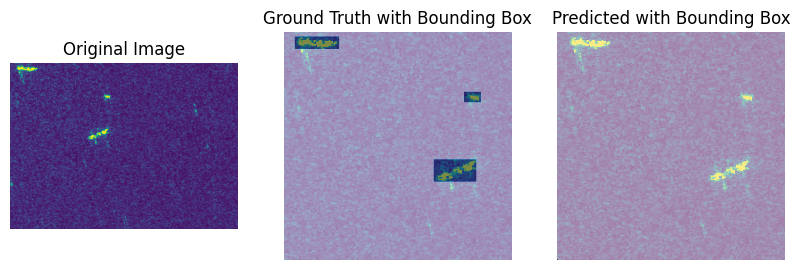

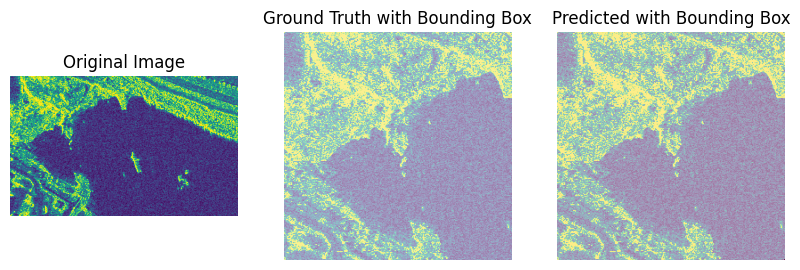

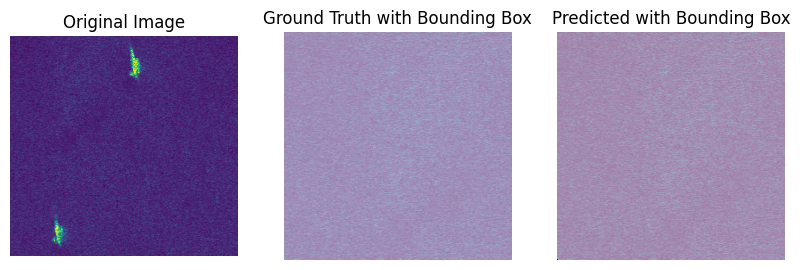

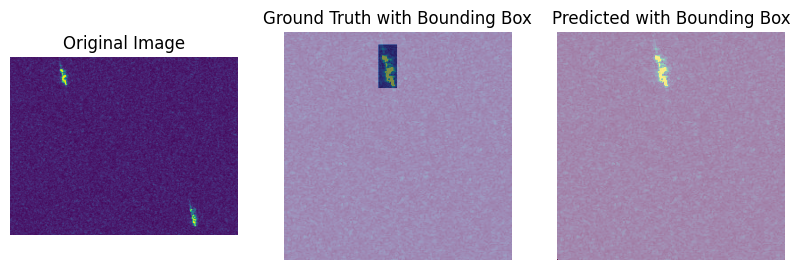

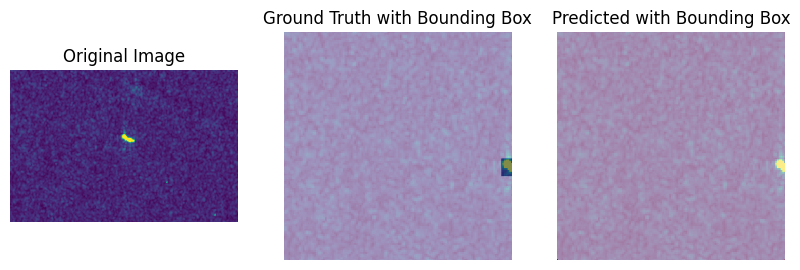

In [ ]:
import matplotlib.pyplot as plt

def create_segmentation_masks(xml_path, image_size):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        mask = np.zeros(image_size, dtype=np.uint8)

        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            mask[ymin:ymax, xmin:xmax] = 1

        return mask
    except FileNotFoundError:
        print(f"XML file '{xml_path}' not found.")
        return None

y_pred_masks = []
for image_path in test_images:
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    pred_mask = model.predict(img)
    y_pred_masks.append(pred_mask.squeeze())

# Visualize bounding boxes on images
def visualize_bounding_boxes(images, masks, predictions):
    num_images = len(images)

    for i in range(num_images):
        image = images[i]
        mask = masks[i]
        prediction = predictions[i]

        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        mask = create_segmentation_masks(mask, (256, 256))
        plt.figure(figsize=(10, 5))

        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')

        # Plot ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.5, cmap='Blues')
        plt.title("Ground Truth with Bounding Box")
        plt.axis('off')

        # Plot predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(image)
        plt.imshow(prediction, alpha=0.5, cmap='Reds')
        plt.title("Predicted with Bounding Box")
        plt.axis('off')

        plt.show()

y_pred = model.predict(test_gen)
# Visualize bounding boxes on some sample images
visualize_bounding_boxes(test_images[:5], test_masks[:5], y_pred_masks[:5])

In [9]:
# Imports and setup
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, DepthwiseConv2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import xml.etree.ElementTree as ET
from google.colab import drive

# Drive mount
drive.mount('/content/drive')

# Paths setup
images_path = '/content/drive/MyDrive/JPEGImages'
masks_path = '/content/drive/MyDrive/Annotations'

# Data check
if not os.path.exists(images_path) or not os.path.exists(masks_path):
    raise ValueError("Image or mask directory not found.")

# Data preparation
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.xml')])

if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory.")

# Split dataset
train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def create_segmentation_masks(xml_path, image_size):
    if not os.path.isfile(xml_path):
        raise FileNotFoundError(f"XML file '{xml_path}' does not exist.")
    tree = ET.parse(xml_path)
    root = tree.getroot()

    mask = np.zeros(image_size, dtype=np.uint8)
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        if bbox is None:
            continue
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        xmin = max(min(xmin, image_size[1]), 0)
        xmax = max(min(xmax, image_size[1]), 0)
        ymin = max(min(ymin, image_size[0]), 0)
        ymax = max(min(ymax, image_size[0]), 0)

        if xmax <= xmin or ymax <= ymin:
            continue
        mask[ymin:ymax, xmin:xmax] = 1

    if np.sum(mask) == 0:
        return None
    return mask

def adjust_data(img, mask):
    img = img / 255.0
    mask = mask / 255.0
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return img, mask

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size
        # Filtering out the paths where the mask would be None (empty or invalid annotations)
        self.valid_indices = [i for i, xml_path in enumerate(self.masks_paths) if create_segmentation_masks(xml_path, self.image_size) is not None]
        self.images_paths = [self.images_paths[i] for i in self.valid_indices]
        self.masks_paths = [self.masks_paths[i] for i in self.valid_indices]

    def __len__(self):
        # This makes sure the DataGenerator works even if the number of images isn't divisible by the batch_size.
        return (len(self.valid_indices) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = min((idx + 1) * self.batch_size, len(self.images_paths))

        x = np.zeros((end - start, *self.image_size, 1), dtype=np.float32)
        y = np.zeros((end - start, *self.image_size, 1), dtype=np.float32)

        for i, img_path in enumerate(self.images_paths[start:end]):
            xml_path = self.masks_paths[start:end][i]  # Synchronized access

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = create_segmentation_masks(xml_path, self.image_size)

            if img is None or mask is None:
                continue  # Skip invalid samples

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            x[i], y[i] = adjust_data(img, mask)

        return x, y

def DeepLabV3(input_shape=(256, 256, 3), num_classes=2):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Extract features at different stages
    layer_names = [
        'block_1_expand_relu',   # 128x128
        'block_3_expand_relu',   # 64x64
        'block_6_expand_relu',   # 32x32
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]

    down_stack = Model(inputs=base_model.input, outputs=layers)
    down_stack.trainable = False

    inputs = Input(shape=input_shape)
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]  # last layer in the down_stack

    # Atrous Spatial Pyramid Pooling
    # 1x1 conv
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False)(x)
    b0 = BatchNormalization()(b0)
    b0 = Activation('relu')(b0)

    # 3x3 conv rate 6
    b1 = DepthwiseConv2D((3, 3), dilation_rate=(6, 6), padding='same', use_bias=False)(x)
    b1 = BatchNormalization()(b1)
    b1 = Activation('relu')(b1)
    b1 = Conv2D(256, (1, 1), padding='same', use_bias=False)(b1)
    b1 = BatchNormalization()(b1)
    b1 = Activation('relu')(b1)

    # Global Average Pooling
    b2 = GlobalAveragePooling2D()(x)
    b2 = Reshape((1, 1, x.shape[-1]))(b2)  # Reshape using the dynamic number of channels from `x`
    b2 = Conv2D(256, (1, 1), padding='same', use_bias=False)(b2)
    b2 = BatchNormalization()(b2)
    b2 = Activation('relu')(b2)
    b2 = UpSampling2D(size=(input_shape[0] // x.shape[1], input_shape[1] // x.shape[2]), interpolation='bilinear')(b2)

    # Concatenate the atrous and image-level features
    x = Concatenate()([b0, b1, b2])

    # Additional upsampling and concatenations with skip connections
    for skip in reversed(skips[:-1]):
        x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip])

    # Classifier
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Instantiate and compile the model
model = DeepLabV3(input_shape=(256, 256, 3), num_classes=2)

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Instantiate and compile the model
model = DeepLabV3()
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

# Generate predictions on the test dataset
test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)

# Predict probabilities
y_pred = model.predict(test_gen)

# Flatten the ground truth masks and predictions
y_true_flat = np.concatenate([test_gen[i][1].flatten() for i in range(len(test_gen))])
y_pred_flat = y_pred.flatten()

# Binarize predictions
y_pred_binary = (y_pred_flat > 0.5).astype(int)

# Compute IoU (Jaccard Index)
def compute_iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union

# Compute Dice coefficient
def compute_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice

# Compute PSNR
def compute_psnr(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Compute F1 score
f1 = f1_score(y_true_flat, y_pred_binary)

# Compute mAP
def compute_ap(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return average_precision_score(y_true, y_pred)

mAP = compute_ap(y_true_flat, y_pred_flat)

# Debug statements
print("Ground Truth Masks Shape:", y_true_flat.shape)
print("Predicted Masks Shape:", y_pred_binary.shape)
print("Unique Values in Ground Truth Masks:", np.unique(y_true_flat))
print("Unique Values in Predicted Masks:", np.unique(y_pred_binary))

print("Intersection over Union (IoU):", compute_iou(y_true_flat, y_pred_binary))
print("Dice Coefficient:", compute_dice(y_true_flat, y_pred_binary))
print("Peak Signal to Noise Ratio (PSNR):", compute_psnr(y_true_flat, y_pred_binary))
print("F1 Score:", f1)
print("Mean Average Precision (mAP):", mAP)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true_flat, y_pred_flat)

# Compute ROC area under curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation accuracy

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 32, 32, 256), (None, 32, 32, 256), (None, 8, 8, 256)]

In [ ]:
import matplotlib.pyplot as plt

def create_segmentation_masks(xml_path, image_size):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        mask = np.zeros(image_size, dtype=np.uint8)

        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            mask[ymin:ymax, xmin:xmax] = 1

        return mask
    except FileNotFoundError:
        print(f"XML file '{xml_path}' not found.")
        return None

y_pred_masks = []
for image_path in test_images:
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    pred_mask = model.predict(img)
    y_pred_masks.append(pred_mask.squeeze())

# Visualize bounding boxes on images
def visualize_bounding_boxes(images, masks, predictions):
    num_images = len(images)

    for i in range(num_images):
        image = images[i]
        mask = masks[i]
        prediction = predictions[i]

        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        mask = create_segmentation_masks(mask, (256, 256))
        plt.figure(figsize=(10, 5))

        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')

        # Plot ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.5, cmap='Blues')
        plt.title("Ground Truth with Bounding Box")
        plt.axis('off')

        # Plot predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(image)
        plt.imshow(prediction, alpha=0.5, cmap='Reds')
        plt.title("Predicted with Bounding Box")
        plt.axis('off')

        plt.show()

y_pred = model.predict(test_gen)
# Visualize bounding boxes on some sample images
visualize_bounding_boxes(test_images[:5], test_masks[:5], y_pred_masks[:5])

In [ ]:
pspnet(T)

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, AveragePooling2D, UpSampling2D, Activation, Add
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import xml.etree.ElementTree as ET

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Adjust these paths to your dataset
images_path = '/content/drive/MyDrive/JPEGImages'
masks_path = '/content/drive/MyDrive/Annotations'

# Check if the images and masks directories exist
if not os.path.exists(images_path):
    raise ValueError(f"Images directory '{images_path}' not found.")

if not os.path.exists(masks_path):
    raise ValueError(f"Masks directory '{masks_path}' not found.")

# Get list of image files and mask files
images = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.jpg')])
mask_files = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.xml')])

print(len(images), len(mask_files))

# Check if mask files are found
if len(mask_files) == 0:
    raise ValueError("No mask files found in the specified directory. Please check your mask directory.")

print(images)
print(mask_files)

train_images, test_images, train_masks, test_masks = train_test_split(images, mask_files, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

def create_segmentation_masks(xml_path, image_size):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        mask = np.zeros(image_size, dtype=np.uint8)

        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            mask[ymin:ymax, xmin:xmax] = 1

        return mask
    except FileNotFoundError:
        print(f"XML file '{xml_path}' not found.")
        return None

class DataGenerator(tf.keras.utils.Sequence):
    def _init_(self, images_paths, masks_paths, batch_size=8, image_size=(256, 256)):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.batch_size = batch_size
        self.image_size = image_size

    def _len_(self):
        return len(self.images_paths) // self.batch_size

    def _getitem_(self, idx):
        batch_x = self.images_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.float32)

        for i, (img_path, xml_path) in enumerate(zip(batch_x, batch_y)):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError(f"Could not load image '{img_path}'.")
            mask = create_segmentation_masks(xml_path, self.image_size)
            if mask is None:
                raise ValueError(f"Could not create mask for image '{img_path}'.")

            img = cv2.resize(img, self.image_size)
            mask = cv2.resize(mask, self.image_size)

            img = np.expand_dims(img, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            x[i], y[i] = adjust_data(img, mask)

        return x, y

def pspnet(input_shape=(256, 256, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    x = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    pool1 = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    x = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    pool2 = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    x = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    pool3 = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    drop4 = tf.keras.layers.Dropout(0.5)(x)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    x = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    x = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    drop5 = Dropout(0.5)(x)

    feature_map_size = drop5.shape[1:3]

    # Dynamic Pyramid Pooling Module
    pooled_outputs = []
    pool_sizes = [1, 2, 3, 6]
    for pool_size in pool_sizes:
        x_pool = AveragePooling2D(pool_size=(input_shape[0] // pool_size, input_shape[1] // pool_size), padding='same')(drop5)
        x_pool = Conv2D(512, 1, activation='relu', padding='same')(x_pool)
        x_pool = UpSampling2D(size=(input_shape[0] // pool_size, input_shape[1] // pool_size), interpolation='bilinear')(x_pool)
        # Resize explicitly to the feature map size before concatenation
        x_pool = tf.image.resize(x_pool, (feature_map_size[0], feature_map_size[1]), method='bilinear')
        pooled_outputs.append(x_pool)

    x = concatenate(pooled_outputs + [drop5], axis=-1)

    # Decoder
    x = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    # More decoder layers follow...

    outputs = Conv2D(num_classes, 1, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = pspnet(input_shape=(256, 256, 1), num_classes=2)

batch_size = 8
train_gen = DataGenerator(train_images, train_masks, batch_size=batch_size)
val_gen = DataGenerator(val_images, val_masks, batch_size=batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture training history
history = model.fit(train_gen,
                    epochs=25,  # Adjust based on your needs
                    validation_data=val_gen,
                    callbacks=[early_stopping])

# Plot training, validation, and testing loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_gen = DataGenerator(test_images, test_masks, batch_size=batch_size)
test_loss, test_accuracy = model.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1160 1160
['/content/drive/MyDrive/JPEGImages/000001.jpg', '/content/drive/MyDrive/JPEGImages/000002.jpg', '/content/drive/MyDrive/JPEGImages/000003.jpg', '/content/drive/MyDrive/JPEGImages/000004.jpg', '/content/drive/MyDrive/JPEGImages/000005.jpg', '/content/drive/MyDrive/JPEGImages/000006.jpg', '/content/drive/MyDrive/JPEGImages/000007.jpg', '/content/drive/MyDrive/JPEGImages/000008.jpg', '/content/drive/MyDrive/JPEGImages/000009.jpg', '/content/drive/MyDrive/JPEGImages/000010.jpg', '/content/drive/MyDrive/JPEGImages/000011.jpg', '/content/drive/MyDrive/JPEGImages/000012.jpg', '/content/drive/MyDrive/JPEGImages/000013.jpg', '/content/drive/MyDrive/JPEGImages/000014.jpg', '/content/drive/MyDrive/JPEGImages/000015.jpg', '/content/drive/MyDrive/JPEGImages/000016.jpg', '/content/drive/MyDrive/JPEGImages/000017.jpg', '/content/drive/MyDrive/JPEGImages/000018.jp

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 16, 16, 512), (None, 16, 16, 512), (None, 15, 15, 512), (None, 16, 16, 512), (None, 16, 16, 1024)]